In [26]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch
import torch.autograd
from torch.optim import AdamW, SGD, Adam
import torch.nn

import blah
import random
import stim
import stim_model
import cpn_model

torch.autograd.set_detect_anomaly(True)


steps = 200
target = torch.zeros((256, steps))
for bidx in range(256):
    for i in range(-100, 100):
        offset = bidx / 256.0
        t = 6 * (i / 100.0) + offset
        target[bidx, i + 100] = torch.sin(torch.tensor(t))

cpn = cpn_model.CPNModel(2, 1, num_neurons=7, activation_func=torch.nn.Tanh)
ben = stim_model.StimModel(1 + 1, 1, num_neurons=4)



class Thing(object):
    def __init__(self, init=0.0, decay=0.7):
        assert isinstance(init, float)
        self.x = init
        self.decay = decay

    def observe(self):
        return self.x

    def step(self, input):
        assert isinstance(input, float)
        self.x += input
        self.x = self.decay * self.x



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
loss = torch.nn.MSELoss()

opt = AdamW(ben.parameters(), lr=5e-3)
for eidx in range(2000):
    ben.reset()
    opt.zero_grad()
    s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)
    thing = [Thing(init=x.item()) for x in target[:,0]]
    pred = torch.zeros((256, steps))
    prev_stim = torch.zeros((256,1))
    hist = torch.zeros(256, steps)

    for tidx in range(steps):   
        obs = []
        for bidx in range(256):
            obs.append(thing[bidx].observe())
        new_obs = torch.tensor(obs).reshape(256,1)
        ben_in = torch.cat((new_obs, prev_stim), axis=1)
        cur_pred = ben(ben_in)
        pred[:, tidx] = cur_pred.squeeze()
        hist[:, tidx] = new_obs.squeeze()
        
        
        # Generate random stim
        if random.random() > 0.3:
            new_stim = torch.tensor([random.uniform(-1, 1) for _ in range(256)]).reshape(256,1)
        else:
            new_stim = torch.zeros(256,1)
        s.add(new_stim)
        n = s.get_next()
        for bidx in range(256):
            thing[bidx].step(n[bidx, 0].item())

        prev_stim = new_stim
            
        
    rl = loss(pred, hist)
    print(eidx, rl.item())
    rl.backward()
    opt.step()

for param in ben.parameters():
    param.requires_grad=False

0 0.0619313046336174
1 0.056906212121248245
2 0.05586416274309158
3 0.054693203419446945
4 0.05466002598404884
5 0.052223823964595795
6 0.047015491873025894
7 0.047405093908309937
8 0.048823922872543335
9 0.04725871980190277
10 0.04536447674036026
11 0.043648555874824524
12 0.04137488454580307
13 0.040067922323942184
14 0.04046105220913887
15 0.03964405134320259
16 0.03712647780776024
17 0.03667512163519859
18 0.03377459943294525
19 0.036789897829294205
20 0.03759987652301788
21 0.03377711400389671
22 0.03501319885253906
23 0.03764099255204201
24 0.035689301788806915
25 0.03470003232359886
26 0.03824915736913681
27 0.03447790816426277
28 0.036539457738399506
29 0.033797573298215866
30 0.03494176268577576
31 0.03275936096906662
32 0.03194922208786011
33 0.03225653991103172
34 0.03296734392642975
35 0.03287136182188988
36 0.0320841446518898
37 0.03265845775604248
38 0.032752953469753265
39 0.03483588621020317
40 0.03488023579120636
41 0.03120134398341179
42 0.031029529869556427
43 0.0325

329 0.000629390764515847
330 0.0006270748563110828
331 0.0007223577704280615
332 0.0006132192211225629
333 0.0006537616718560457
334 0.0005297276074998081
335 0.0006476060952991247
336 0.0006860975408926606
337 0.0006360103143379092
338 0.0005999161512590945
339 0.0006718117510899901
340 0.000574842793866992
341 0.0006500777672044933
342 0.0005636851419694722
343 0.0007970759179443121
344 0.0008131175418384373
345 0.0006879229913465679
346 0.0006685322732664645
347 0.0006161314086057246
348 0.0006033463287167251
349 0.0005121439462527633
350 0.0006273085018619895
351 0.0006998577737249434
352 0.0007564973784610629
353 0.0005050140316598117
354 0.0005679528694599867
355 0.0005772376898676157
356 0.0006638545310124755
357 0.000632080715149641
358 0.000578694511204958
359 0.0006327077280730009
360 0.0005869542947039008
361 0.0006697127828374505
362 0.0005170718068256974
363 0.0005281777703203261
364 0.000609532289672643
365 0.0006348677561618388
366 0.0006274013430811465
367 0.00052550365

641 6.254331674426794e-05
642 6.394649244612083e-05
643 7.186604489106685e-05
644 6.54414325254038e-05
645 6.505368946818635e-05
646 5.533807780011557e-05
647 5.40297114639543e-05
648 6.678911449853331e-05
649 7.513580203521997e-05
650 6.198257324285805e-05
651 5.711255653295666e-05
652 6.977518205530941e-05
653 6.09315829933621e-05
654 5.066314770374447e-05
655 6.602292705792934e-05
656 6.991093687247485e-05
657 6.729327287757769e-05
658 4.7597299271728843e-05
659 5.458520172396675e-05
660 5.907977174501866e-05
661 5.640072777168825e-05
662 5.964607771602459e-05
663 5.803691237815656e-05
664 5.424475239124149e-05
665 5.160248838365078e-05
666 5.553444862016477e-05
667 5.0895985623355955e-05
668 6.106193904997781e-05
669 5.379586582421325e-05
670 6.22939332970418e-05
671 5.201746535021812e-05
672 5.38636559213046e-05
673 5.8846511819865555e-05
674 5.296135350363329e-05
675 6.18704580119811e-05
676 6.596589082619175e-05
677 5.369694918044843e-05
678 5.9512116422411054e-05
679 5.19749555

953 2.9726048524025828e-05
954 3.251915404689498e-05
955 3.2666845072526485e-05
956 3.2315627322532237e-05
957 2.9686716516152956e-05
958 2.9594177249236964e-05
959 3.11489675368648e-05
960 2.813708306348417e-05
961 3.0188313758117147e-05
962 2.5316548999398947e-05
963 2.5659688617452048e-05
964 2.6314874048694037e-05
965 2.6265748601872474e-05
966 2.8831842428189702e-05
967 3.203337837476283e-05
968 2.6675383196561597e-05
969 2.9708473448408768e-05
970 2.709954969759565e-05
971 2.9642800654983148e-05
972 2.6618025003699586e-05
973 2.618383223307319e-05
974 2.792305349430535e-05
975 2.6791631171363406e-05
976 2.912965828727465e-05
977 3.05113717331551e-05
978 2.627886351547204e-05
979 2.775992288661655e-05
980 2.652849980222527e-05
981 2.5894894861266948e-05
982 2.6821708161151037e-05
983 2.790226790239103e-05
984 2.7415484510129318e-05
985 2.686591506062541e-05
986 2.8772925361408852e-05
987 2.9241768061183393e-05
988 2.58153049799148e-05
989 2.7419217076385394e-05
990 2.9051321689621

1251 2.0711655452032574e-05
1252 2.083604886138346e-05
1253 2.0191939256619662e-05
1254 2.0446614144020714e-05
1255 2.0310610125306994e-05
1256 2.3947837689775042e-05
1257 2.0669376681325957e-05
1258 2.2772290321881883e-05
1259 2.0286017388571054e-05
1260 2.1619844119413756e-05
1261 1.999956111831125e-05
1262 2.017312181123998e-05
1263 1.969158256542869e-05
1264 2.0636887711589225e-05
1265 1.8941178495879285e-05
1266 2.008815499721095e-05
1267 1.970696757780388e-05
1268 2.0896102796541527e-05
1269 2.1477622794918716e-05
1270 1.8958600776386447e-05
1271 2.1724190446548164e-05
1272 2.2095600797911175e-05
1273 1.9588813302107155e-05
1274 2.0537301679723896e-05
1275 1.863738907559309e-05
1276 2.3211725419969298e-05
1277 2.0520419639069587e-05
1278 1.9616330973803997e-05
1279 2.1123982151038945e-05
1280 2.0058090740349144e-05
1281 1.9256400264566764e-05
1282 1.9249757315265015e-05
1283 2.0581357603077777e-05
1284 2.1979481971357018e-05
1285 1.9608121874625795e-05
1286 1.9470255210762843e-05

1548 1.5773281120345928e-05
1549 1.6045891243265942e-05
1550 1.6243471691268496e-05
1551 1.602362135599833e-05
1552 1.925295146065764e-05
1553 1.5451445506187156e-05
1554 1.579447962285485e-05
1555 1.657680877542589e-05
1556 1.6695026715751737e-05
1557 1.6298410628223792e-05
1558 1.619042450329289e-05
1559 1.5203931980067864e-05
1560 1.433524266758468e-05
1561 1.5325784261221997e-05
1562 1.7546937669976614e-05
1563 1.582475124450866e-05
1564 1.6778980352682993e-05
1565 1.5674773749196902e-05
1566 1.610752588021569e-05
1567 1.6573345419601537e-05
1568 1.5972616893122904e-05
1569 1.655790583754424e-05
1570 1.5916859410936013e-05
1571 1.565263664815575e-05
1572 1.643032010179013e-05
1573 1.631784107303247e-05
1574 1.7367181499139406e-05
1575 1.4861309864500072e-05
1576 1.630483166081831e-05
1577 1.7420397853129543e-05
1578 1.5482737580896355e-05
1579 1.4995598576206248e-05
1580 1.6399739251937717e-05
1581 1.756224264681805e-05
1582 1.4463406841969118e-05
1583 1.4778805962123442e-05
1584 1

1844 1.3057678188488353e-05
1845 1.314223300141748e-05
1846 1.2641150533454493e-05
1847 1.3542161468649283e-05
1848 1.2316407264734153e-05
1849 1.3792530808132142e-05
1850 1.2055234947183635e-05
1851 1.257922122022137e-05
1852 1.2736792996292934e-05
1853 1.3129644685250241e-05
1854 1.2588723620865494e-05
1855 1.5286561392713338e-05
1856 1.4167851986712776e-05
1857 1.3626301551994402e-05
1858 1.374466319248313e-05
1859 1.3582794963440392e-05
1860 1.2929828699270729e-05
1861 1.4624285540776327e-05
1862 1.3052106623945292e-05
1863 1.3560793377109803e-05
1864 1.4030209058546461e-05
1865 1.3100308024149854e-05
1866 1.2513993169704918e-05
1867 1.3769592442258727e-05
1868 1.455918845749693e-05
1869 1.3300395949045196e-05
1870 1.2349200005701277e-05
1871 1.3138278518454172e-05
1872 1.4513429050566629e-05
1873 1.282424545934191e-05
1874 1.5459268979611807e-05
1875 1.330548639089102e-05
1876 1.1994120541203301e-05
1877 1.3888494322600309e-05
1878 1.1444079063949175e-05
1879 1.2377406164887361e-0

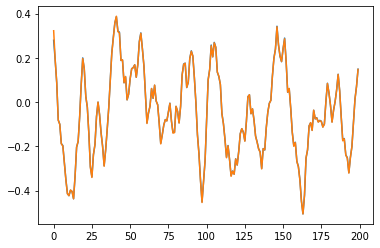

In [24]:
plt.plot(hist[0,:])
plt.plot(pred[0,:].detach().numpy())
plt.show()

In [ ]:
cpni = []
loss = torch.nn.MSELoss()
opt = AdamW(cpn.parameters(), lr=6e-3)
for eidx in range(100):
    cpn.reset()
    ben.reset()
    for param in ben.parameters():
        param.grad = None
    opt.zero_grad()
    thing = [Thing(init=x.item()) for x in target[:,0]]

    cur = target[:,0].reshape(256,1)
    pred = torch.zeros((256, steps))
    s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)

    obs = [t.observe() for t in thing]
    new_obs = torch.tensor(obs).reshape(256,1)

    for tidx in range(steps):
        cpn_in = torch.cat((new_obs, target[:,tidx].reshape(256,1)), axis=1)
        new_stim = cpn(cpn_in)

        s.add(new_stim)
        n = s.get_next()

        obs = []
        for bidx in range(256):
            thing[bidx].step(n[bidx, 0].item())
            obs.append(thing[bidx].observe())

        new_obs = torch.tensor(obs).reshape(256,1)
        ben_in = torch.cat((new_obs, new_stim), axis=1)
        cur_pred = ben(ben_in)
        pred[:, tidx] = cur_pred.squeeze()

    rl = loss(pred, target)
    print(eidx, rl.item())
    rl.backward()
    opt.step()
    cpni.append(cpn.I.clone())

plt.plot(pred[0,:].detach().numpy())
plt.plot(target[0,:].detach().numpy())
plt.show()

import h5py
f = h5py.File('blah.hdf5', 'w')
cpnic = torch.cat(cpni)
f['blah'] = cpnic.detach().numpy()
f.close()
